<a href="https://colab.research.google.com/github/ravisiv/APIClassification/blob/main/APIClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Classification Of APIs using API data and metadata
#### Ravi Sivaraman

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import pandas as pd
import yaml
import io
import os
from urllib.parse import urlparse

In [2]:
username = os.getlogin( )
api_home_path = None
api_df =None

if username == 'ravis':
    #This is my laptop
    api_home_path = "/Users/ravis/Documents/GitHub/openapi-directory/APIs/"
    api_df = pd.read_csv(api_home_path + "apis.csv")
else:
    #this is on Google Colab
    api_home_path = "/content/drive/MyDrive/APIs/"
    api_df = pd.read_csv(api_home_path + "apis.csv")
    apis_df = pd.read_csv(/content/apis_parsed.csv)

OSError: ignored

In [4]:
  apis_df = pd.read_csv( "/content/apis_parsed.csv")

In [8]:
api_home_path = "/content/drive/MyDrive/APIs/"

In [5]:
## TODO: rewrite it as get_n_tags()

def get_three_tags(tagslist):
    index = 0
    threetags = []
    for tag in range(0,3):
        try:
            item  = tagslist[tag]
            threetags.append(item)
        except IndexError:
            threetags.append('')
    return threetags



### Parse all APIs

In [6]:
import re
api_rows = []
for index, row in api_df.iterrows():
    try:
        with open(api_home_path+row['API'], 'r') as stream:
            data_loaded = yaml.safe_load(stream)
            data_items =  list(data_loaded.keys())
            api_type = data_items[0]
            api_http_types = []
            api_schemes = []
            base_path = ""
            api_scheme_count = 0
            api_schemes_combined = 0
            api_schemes.sort()
            api_scheme_count = len(api_schemes)
            api_schemes_combined = "|".join(api_schemes)
            api_https_supported = 0
            api_responses_count = 0
            if api_type == "swagger":
                api_schemes = data_loaded['schemes']
                api_scheme_count = len(api_schemes)
                api_schemes_combined = "|".join(api_schemes)
                api_https_supported = 1 if "https" in api_schemes_combined else 0
                basePath = data_loaded["basePath"]
                host = data_loaded["host"]
                main_description = data_loaded["info"]["description"]
                paths = data_loaded["paths"]
                for key2, val2 in paths.items():
                    api_name = key2
                    api_http_type = list(val2.keys())[0]
                    api_http_types.append(api_http_type)
                    api_summary = main_description + " " + val2[api_http_type]['summary']
                    api_tags = val2[api_http_type]['tags']
                    try:
                        api_responses_count = len(val2[api_http_type]['responses'])
                    except:
                        pass

                    api_summary_2 = ""
                    if api_summary:
                        api_summary_2 = re.sub('\W+',' ', api_summary.lower() ) 
                        if api_tags and type(api_tags) is list:
                            api_summary_2 += " " + " ".join(api_tags)
                            api_summary_2 =  api_summary_2.lower()
                    api_row = [api_type,host,basePath,api_name,api_http_type, api_summary,api_summary_2,api_schemes_combined,api_scheme_count,api_responses_count,api_https_supported] + get_three_tags(api_tags)
                    api_rows.append(api_row)
 
                
            elif api_type == "openapi":
                api_servers = data_loaded['servers']
                api_paths = data_loaded['paths']
                api_schemes = []
                api_scheme_count = 0
                apis.append(api_row + ["".join(api_summary_2)] )
                main_description = data_loaded["info"]["description"]

                for api_server in api_servers:
                    host = api_server['url']
                    api_scheme = list(api_server.values())[0]
                    api_scheme = urlparse(api_scheme)[0]
                    api_schemes.append(api_scheme)
                api_schemes.sort()
                api_schemes = list(set(api_schemes))
                api_schemes_combined = "|".join(api_schemes)
                api_scheme_count = len(api_schemes)
                paths = data_loaded["paths"]

                for key2, val2 in paths.items():
                    api_name = key2
                    api_http_type = list(val2.keys())[0]
                    api_http_types.append(api_http_type)
                    api_summary = main_description + " " + val2[api_http_type]['summary']
                    api_tags = val2[api_http_type]['tags']
                    try:
                        api_responses_count = len(val2[api_http_type]['responses'])
                    except:
                        pass


                    api_summary_2 = ""
                    if api_summary:
                        api_summary_2 = re.sub('\W+',' ', api_summary.lower() ) 
                        if api_tags and type(api_tags) is list:
                            api_summary_2 += " " + " ".join(api_tags)
                            api_summary_2 =  api_summary_2.lower()
                    api_row = [api_type,host,basePath,api_name,api_http_type, api_summary,api_summary_2,api_schemes_combined,api_scheme_count,api_responses_count,api_https_supported] + get_three_tags(api_tags)        
                    api_rows.append(api_row)

    except Exception as e:
        continue
apis_df = pd.DataFrame.from_records(api_rows, columns=['api_type','host','basePath','api_name','api_http_type','api_summary','api_summary_2','api_schemes','api_schemes_count','api_responses_count','api_https_supported','tag1', 'tag2', 'tag3',])


#Reference: https://towardsdatascience.com/how-to-cluster-similar-sentences-using-tf-idf-and-graph-partitioning-in-python-5fb70627a4e0


NameError: ignored

In [12]:
apis_df

,Unnamed: 0,api_type,host,basePath,api_name,api_http_type,api_summary,api_summary_2,api_schemes,api_schemes_count,api_responses_count,api_https_supported,tag1,tag2,tag3
0,0,swagger,1forge.com,/forex-quotes,/quotes,get,Stock and Forex Data and Realtime Quotes Get q...,stock and forex data and realtime quotes get q...,https|http,2,1,1,forex,finance,quotes
1,1,swagger,1forge.com,/forex-quotes,/symbols,get,Stock and Forex Data and Realtime Quotes Get a...,stock and forex data and realtime quotes get a...,https|http,2,1,1,forex,finance,quotes
2,2,swagger,io.adafruit.com,/api/v2,/user,get,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Users,NaN,NaN
3,3,swagger,io.adafruit.com,/api/v2,/webhooks/feed/:token,post,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Webhooks,Data,NaN
4,4,swagger,io.adafruit.com,/api/v2,/webhooks/feed/:token/raw,post,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Webhooks,Data,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,2818,swagger,www.zoomconnect.com,/app,/api/rest/v1/templates/{templateId},delete,The world's greatest SMS API delete,the world s greatest sms api delete templates,https,1,4,1,templates,NaN,NaN
2819,2819,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/all,get,The world's greatest SMS API all,the world s greatest sms api all voice,https,1,4,1,voice,NaN,NaN
2820,2820,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/single-audio,post,The world's greatest SMS API single-audio,the world s greatest sms api single audio voice,https,1,5,1,voice,NaN,NaN
2821,2821,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/single-text,post,The world's greatest SMS API single-text,the world s greatest sms api single text voice,https,1,5,1,voice,NaN,NaN


In [ ]:
api_rows = []
with open("/Users/ravis/Documents/GitHub/openapi-directory/APIs/1forge.com/0.0.1/swagger.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)
    data_items =  list(data_loaded.keys())
    api_type = data_items[0]
    api_http_types = []
    api_schemes = []
    base_path = ""
    api_scheme_count = 0
    api_schemes_combined = 0
    api_schemes.sort()
    api_scheme_count = len(api_schemes)
    api_schemes_combined = "|".join(api_schemes)
    api_https_supported = 0
    api_responses_count = 0
    if api_type == "swagger":
        api_schemes = data_loaded['schemes']
        api_scheme_count = len(api_schemes)
        api_schemes_combined = "|".join(api_schemes)
        api_https_supported = 1 if "https" in api_schemes_combined else 0
        basePath = data_loaded["basePath"]
        host = data_loaded["host"]
        main_description = data_loaded["info"]["description"]
        paths = data_loaded["paths"]
        for key2, val2 in paths.items():
            api_name = key2
            api_http_type = list(val2.keys())[0]
            api_http_types.append(api_http_type)
            api_summary = main_description + " " + val2[api_http_type]['summary']
            api_tags = val2[api_http_type]['tags']
            try:
                api_responses_count = len(val2[api_http_type]['responses'])
            except:
                pass

            api_summary_2 = ""
            if api_summary:
                api_summary_2 = re.sub('\W+',' ', api_summary.lower() ) 
                if api_tags and type(api_tags) is list:
                    api_summary_2 += " " + " ".join(api_tags)
                    api_summary_2 =  api_summary_2.lower()
            api_row = [api_type,host,basePath,api_name,api_http_type, api_summary,api_summary_2,api_schemes_combined,api_scheme_count,api_responses_count] + get_three_tags(api_tags)


            api_rows.append(api_row)

apis_df = pd.DataFrame.from_records(api_rows, columns=['api_type','host','basePath','api_name','api_http_type','api_summary',"api_summary_2",'api_schemes','api_schemes_count','api_responses_count','tag1', 'tag2', 'tag3'])




In [7]:
apis_df

,Unnamed: 0,api_type,host,basePath,api_name,api_http_type,api_summary,api_summary_2,api_schemes,api_schemes_count,api_responses_count,api_https_supported,tag1,tag2,tag3
0,0,swagger,1forge.com,/forex-quotes,/quotes,get,Stock and Forex Data and Realtime Quotes Get q...,stock and forex data and realtime quotes get q...,https|http,2,1,1,forex,finance,quotes
1,1,swagger,1forge.com,/forex-quotes,/symbols,get,Stock and Forex Data and Realtime Quotes Get a...,stock and forex data and realtime quotes get a...,https|http,2,1,1,forex,finance,quotes
2,2,swagger,io.adafruit.com,/api/v2,/user,get,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Users,NaN,NaN
3,3,swagger,io.adafruit.com,/api/v2,/webhooks/feed/:token,post,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Webhooks,Data,NaN
4,4,swagger,io.adafruit.com,/api/v2,/webhooks/feed/:token/raw,post,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Webhooks,Data,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,2818,swagger,www.zoomconnect.com,/app,/api/rest/v1/templates/{templateId},delete,The world's greatest SMS API delete,the world s greatest sms api delete templates,https,1,4,1,templates,NaN,NaN
2819,2819,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/all,get,The world's greatest SMS API all,the world s greatest sms api all voice,https,1,4,1,voice,NaN,NaN
2820,2820,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/single-audio,post,The world's greatest SMS API single-audio,the world s greatest sms api single audio voice,https,1,5,1,voice,NaN,NaN
2821,2821,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/single-text,post,The world's greatest SMS API single-text,the world s greatest sms api single text voice,https,1,5,1,voice,NaN,NaN


In [ ]:
api_rows = []
with open("/Users/ravis/Documents/GitHub/openapi-directory/APIs/1password.com/events/1.0.0/openapi.yaml", 'r') as stream:
    data_loaded = yaml.safe_load(stream)
    data_items =  list(data_loaded.keys())
    api_type = data_items[0]
    api_http_types = []
    api_schemes = []
    base_path = ""
    api_scheme_count = 0
    api_schemes_combined = 0
    api_https_supported = 0
    api_responses_count = 0
    api_servers = data_loaded['servers']
    api_paths = data_loaded['paths']
    api_schemes = []
    api_scheme_count = 0
    apis.append(api_row + ["".join(api_summary_2)] )
    main_description = data_loaded["info"]["description"]
    
    for api_server in api_servers:
        host = api_server['url']
        api_scheme = urlparse(host)[0]
        api_schemes.append(api_scheme)
        print(api_url)
    api_schemes.sort()
    api_schemes = list(set(api_schemes))
    api_schemes_combined = "|".join(api_schemes)
    api_scheme_count = len(api_schemes)
    paths = data_loaded["paths"]

    for key2, val2 in paths.items():
        api_name = key2
        api_http_type = list(val2.keys())[0]
        api_http_types.append(api_http_type)
        api_summary = main_description + " " + val2[api_http_type]['summary']
        api_tags = val2[api_http_type]['tags']
        try:
            api_responses_count = len(val2[api_http_type]['responses'])
        except:
            pass


        api_summary_2 = ""
        if api_summary:
            api_summary_2 = re.sub('\W+',' ', api_summary.lower() ) 
            if api_tags and type(api_tags) is list:
                api_summary_2 += " " + " ".join(api_tags)
                api_summary_2 =  api_summary_2.lower()
        api_row = [api_type,host,basePath,api_name,api_http_type, api_summary,api_summary_2,api_schemes_combined,api_scheme_count,api_responses_count] + get_three_tags(api_tags)        
        api_rows.append(api_row)
apis_df = pd.DataFrame.from_records(api_rows, columns=['api_type','host','basePath','api_name','api_http_type','api_summary',"api_summary_2",'api_schemes','api_schemes_count','api_responses_count','tag1', 'tag2', 'tag3'])

apis_df

https://events.ent.1password.com
https://events.ent.1password.com
https://events.ent.1password.com
https://events.ent.1password.com


,api_type,host,basePath,api_name,api_http_type,api_summary,api_summary_2,api_schemes,api_schemes_count,api_responses_count,tag1,tag2,tag3
0,openapi,https://events.ent.1password.com,/app,/api/auth/introspect,get,1Password Events API Specification. Performs i...,1password events api specification performs in...,https,1,3,auth,,
1,openapi,https://events.ent.1password.com,/app,/api/v1/itemusages,post,1Password Events API Specification. Retrieves ...,1password events api specification retrieves i...,https,1,3,api-v1,,
2,openapi,https://events.ent.1password.com,/app,/api/v1/signinattempts,post,1Password Events API Specification. Retrieves ...,1password events api specification retrieves s...,https,1,3,api-v1,,


,api_type,host,basePath,api_name,api_http_type,api_summary,api_summary_2,api_schemes,api_schemes_count,api_responses_count,tag1,tag2,tag3
0,openapi,www.zoomconnect.com,/app,/accounts/{account_id}/apps,get,Use the Control API to manage your application...,use the control api to manage your application...,https,1,4,apps,,
1,openapi,www.zoomconnect.com,/app,/apps/{app_id}/keys,get,Use the Control API to manage your application...,use the control api to manage your application...,https,1,5,keys,,
2,openapi,www.zoomconnect.com,/app,/apps/{app_id}/keys/{key_id},patch,Use the Control API to manage your application...,use the control api to manage your application...,https,1,7,keys,,
3,openapi,www.zoomconnect.com,/app,/apps/{app_id}/keys/{key_id}/revoke,post,Use the Control API to manage your application...,use the control api to manage your application...,https,1,5,keys,,
4,openapi,www.zoomconnect.com,/app,/apps/{app_id}/namespaces,get,Use the Control API to manage your application...,use the control api to manage your application...,https,1,5,namespaces,,
5,openapi,www.zoomconnect.com,/app,/apps/{app_id}/namespaces/{namespace_id},delete,Use the Control API to manage your application...,use the control api to manage your application...,https,1,5,namespaces,,
6,openapi,www.zoomconnect.com,/app,/apps/{app_id}/queues,get,Use the Control API to manage your application...,use the control api to manage your application...,https,1,6,queues,,
7,openapi,www.zoomconnect.com,/app,/apps/{app_id}/queues/{queue_id},delete,Use the Control API to manage your application...,use the control api to manage your application...,https,1,6,queues,,
8,openapi,www.zoomconnect.com,/app,/apps/{app_id}/rules,get,Use the Control API to manage your application...,use the control api to manage your application...,https,1,5,rules,,
9,openapi,www.zoomconnect.com,/app,/apps/{app_id}/rules/{rule_id},delete,Use the Control API to manage your application...,use the control api to manage your application...,https,1,5,rules,,


In [5]:
def cosine_similarity(text1, text2):
    
    X_list = word_tokenize(text1) 
    Y_list = word_tokenize(text2)

    # sw contains the list of stopwords
    sw = stopwords.words('english') 
    l1 =[];l2 =[]

    # remove stop words from the string
    X_set = {w for w in X_list if not w in sw} 
    Y_set = {w for w in Y_list if not w in sw}

    # form a set containing keywords of both strings 
    rvector = X_set.union(Y_set) 
    for w in rvector:
        if w in X_set: l1.append(1) # create a vector
        else: l1.append(0)
        if w in Y_set: l2.append(1)
        else: l2.append(0)
    c = 0

    # cosine formula 
    for i in range(len(rvector)):
        c+= l1[i]*l2[i]
    cosine = c / float((sum(l1)*sum(l2))**0.5)
    return cosine



## Stem the words in descriptions

In [13]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
from Sastrawi.StopWordRemover.StopWordRemoverFactory import StopWordRemoverFactory

stemmer = StemmerFactory().create_stemmer()
stopwords = StopWordRemoverFactory().get_stop_words()

def text_preprocess(series, stemmer, stopwords):
    df = series.str.replace("\n\t",  " ")
    df = df.str.replace(r"[^a-zA-Z ]+", "")
    df = df.str.lower()
    df = df.apply(lambda x: ' '.join([stemmer.stem(item) for item in x.split() if item not in stopwords]))
    return df

apis_df['processed_text'] = text_preprocess(apis_df['api_summary_2'], stemmer, stopwords)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: FutureWarning: The default value of regex will change from True to False in a future version.
  if __name__ == '__main__':


In [31]:
pip install https://github.com/explosion/spacy-models/releases/download/en_core_web_sm-3.0.0/en_core_web_sm-3.0.0-py3-none-any.whl

     |████████████████████████████████| 13.7 MB 5.2 MB/s 
     |████████████████████████████████| 5.8 MB 4.5 MB/s 
     |████████████████████████████████| 42 kB 1.4 MB/s 
     |████████████████████████████████| 653 kB 56.8 MB/s 
     |████████████████████████████████| 457 kB 56.9 MB/s 
     |████████████████████████████████| 10.1 MB 53.8 MB/s 
     |████████████████████████████████| 58 kB 7.5 MB/s 
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 4.2.0
    Uninstalling typing-extensions-4.2.0:
      Successfully uninstalled typing-extensions-4.2.0
  Attempting uninstall: catalogue
    Found existing installation: catalogue 1.0.0
    Uninstalling catalogue-1.0.0:
      Successfully uninstalled catalogue-1.0.0
  Attempting uninstall: srsly
    Found existing installation: srsly 1.0.5
    Uninstalling srsly-1.0.5:
      Successfully uninstalled srsly-1.0.5
  Attempting uninstall: smart-open
    Found existing installation: smart-open 6.0.0
    U

In [27]:
#pip install spacy
import spacy
nlp = spacy.load("en_core_web_trf")

OSError: ignored

In [6]:
pip install Sastrawi

     |████████████████████████████████| 209 kB 5.2 MB/s 


### Save processed data back to Google Drive

In [14]:
apis_df.to_csv(api_home_path +  "apis_data.csv")

In [7]:
pip install fasttext

     |████████████████████████████████| 68 kB 3.6 MB/s 
  Using cached pybind11-2.9.2-py2.py3-none-any.whl (213 kB)
  Created wheel for fasttext: filename=fasttext-0.9.2-cp37-cp37m-linux_x86_64.whl size=3146116 sha256=e866903293124d1c9dc110a59a66bcb797768c24388b4b61036815b724654ece
  Stored in directory: /root/.cache/pip/wheels/4e/ca/bf/b020d2be95f7641801a6597a29c8f4f19e38f9c02a345bab9b
Successfully built fasttext


In [ ]:
#import fasttext

#model = fasttext.train_unsupervised('/content/drive/MyDrive/APIs/wiki-news-300d-1M.vec')
#apis_df['vec'] = apis_df['processed_text'].apply(lambda x: model.get_sentence_vector(x))

In [10]:
#model.save_model("apimodel.bin")
import fasttext
model = fasttext.load_model(api_home_path + "apimodel.bin")
apis_df['vec'] = apis_df['processed_text'].apply(lambda x: model.get_sentence_vector(x))

In [15]:
apis_df['vec'] = apis_df['processed_text'].apply(lambda x: model.get_sentence_vector(x))

In [ ]:
apis_df['vec']

0       [0.03719435, -0.015253557, -0.04589598, -0.021...
1       [-0.008268558, 0.0031177406, -0.022891957, -0....
2       [0.04091386, -0.046491396, 0.0038976828, -0.00...
3       [0.025302937, 0.015915517, -0.016523104, 0.008...
4       [-0.003093318, 0.0022154166, -0.012527056, 0.0...
                              ...                        
3673    [0.11873129, -0.07086635, -0.02338354, 0.06951...
3674    [0.08758139, -0.109601915, 0.092438266, 0.0939...
3675    [0.10316494, -0.010101309, 0.04449649, 0.09270...
3676    [0.05305753, -0.04358753, 0.06328352, 0.038250...
3677    [-0.04946267, 0.014706102, 0.014475949, 0.0375...
Name: vec, Length: 3678, dtype: object

In [16]:

X =apis_df['vec']

In [20]:
apis_df

,Unnamed: 0,api_type,host,basePath,api_name,api_http_type,api_summary,api_summary_2,api_schemes,api_schemes_count,api_responses_count,api_https_supported,tag1,tag2,tag3,processed_text,vec
0,0,swagger,1forge.com,/forex-quotes,/quotes,get,Stock and Forex Data and Realtime Quotes Get q...,stock and forex data and realtime quotes get q...,https|http,2,1,1,forex,finance,quotes,stock and forex data and realtime quotes get q...,"[0.044204194, -0.04007092, -0.02222717, -0.022..."
1,1,swagger,1forge.com,/forex-quotes,/symbols,get,Stock and Forex Data and Realtime Quotes Get a...,stock and forex data and realtime quotes get a...,https|http,2,1,1,forex,finance,quotes,stock and forex data and realtime quotes get a...,"[0.010976354, -0.019648599, -0.014073594, -0.0..."
2,2,swagger,io.adafruit.com,/api/v2,/user,get,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Users,NaN,NaN,the internet of things for everyone the adafru...,"[0.0020080782, -0.022635706, 0.0026322892, -0...."
3,3,swagger,io.adafruit.com,/api/v2,/webhooks/feed/:token,post,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Webhooks,Data,NaN,the internet of things for everyone the adafru...,"[0.0017162259, -0.021570591, 0.0042702183, -0...."
4,4,swagger,io.adafruit.com,/api/v2,/webhooks/feed/:token/raw,post,### The Internet of Things for Everyone\n\nThe...,the internet of things for everyone the adafr...,https|http,2,5,1,Webhooks,Data,NaN,the internet of things for everyone the adafru...,"[0.0018573268, -0.021731662, 0.004239553, -0.0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2818,2818,swagger,www.zoomconnect.com,/app,/api/rest/v1/templates/{templateId},delete,The world's greatest SMS API delete,the world s greatest sms api delete templates,https,1,4,1,templates,NaN,NaN,the world s greatest sms api delete templates,"[-0.015417464, -0.014599993, 0.045283828, 0.01..."
2819,2819,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/all,get,The world's greatest SMS API all,the world s greatest sms api all voice,https,1,4,1,voice,NaN,NaN,the world s greatest sms api all voice,"[0.016858924, -0.035022926, 0.025386686, 0.019..."
2820,2820,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/single-audio,post,The world's greatest SMS API single-audio,the world s greatest sms api single audio voice,https,1,5,1,voice,NaN,NaN,the world s greatest sms api single audio voice,"[0.017794775, -0.05191738, 0.05857504, 0.03346..."
2821,2821,swagger,www.zoomconnect.com,/app,/api/rest/v1/voice/single-text,post,The world's greatest SMS API single-text,the world s greatest sms api single text voice,https,1,5,1,voice,NaN,NaN,the world s greatest sms api single text voice,"[0.022989295, -0.018750515, 0.042594448, 0.033..."


In [17]:
df_x = pd.DataFrame.from_records(apis_df['vec'])

In [18]:
X = df_x.values

# KMeans Clustering

k 2
k 3
k 4
k 5
k 6
k 7
k 8
k 9
k 10
k 11
k 12
k 13
k 14
k 15
k 16
k 17
k 18
k 19


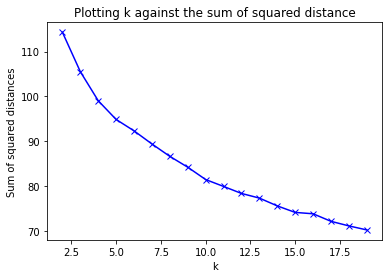

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
sum_of_squared_distances = []
K = range(2,20)
for k in K:
    km = KMeans(n_clusters=k, max_iter=200, n_init=10)
    km = km.fit(X)
    sum_of_squared_distances.append(km.inertia_)
    print("k", k)
plt.plot(K, sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum of squared distances')
plt.title('Plotting k against the sum of squared distance')
plt.show()

### Best value for `K` is `15`

In [21]:
from sklearn.cluster import KMeans
k_val = 15
kmeans = KMeans(n_clusters=k_val)
apis_df['cluster'] = kmeans.fit_predict(apis_df['vec'].values.tolist())

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=3)
apis_df['x'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,0]
apis_df['y'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,1]
apis_df['z'] = pca.fit_transform(apis_df['vec'].values.tolist())[:,2]

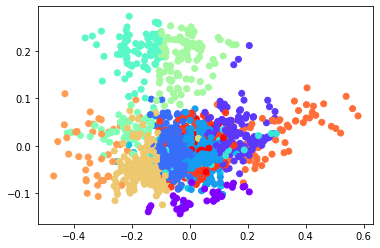

In [23]:
import matplotlib.pyplot as plt

plt.scatter(apis_df['x'], apis_df['y'], c=apis_df['cluster'], cmap='rainbow')

Text(0.5, 0.92, 'Tweet Clustering using K Means')

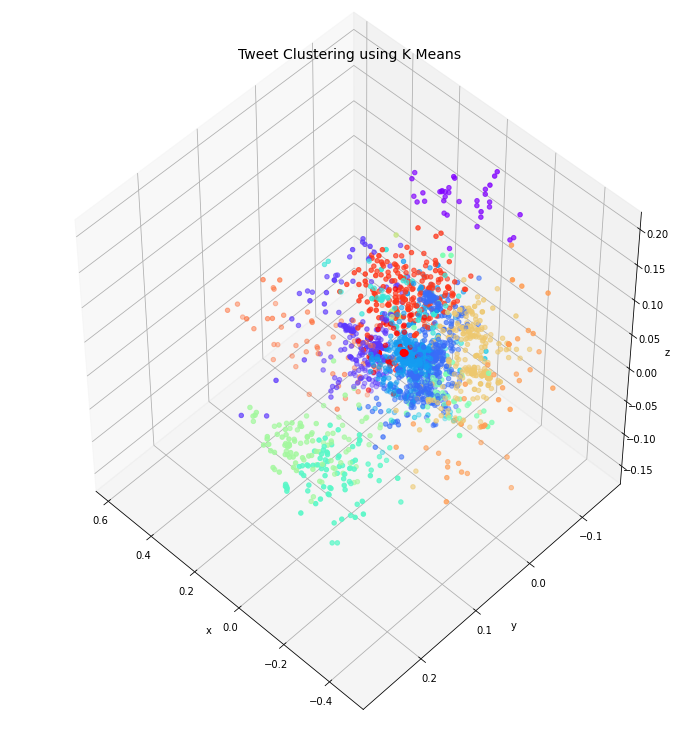

In [24]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(1, figsize=(10,10))
ax = Axes3D(fig, rect=[0, 0, 0.95, 1], elev=48, azim=134)
ax.scatter(apis_df['x'],apis_df['y'],apis_df['z'], c=apis_df['cluster'], cmap='rainbow')
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")
ax.set_facecolor('white')
plt.title("Tweet Clustering using K Means", fontsize=14)

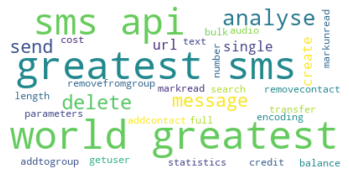

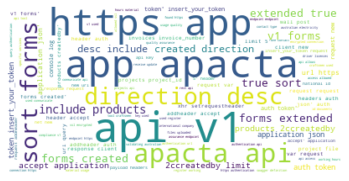

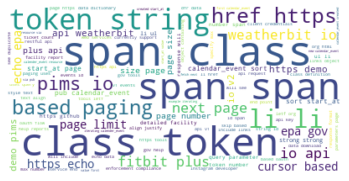

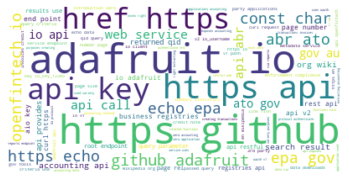

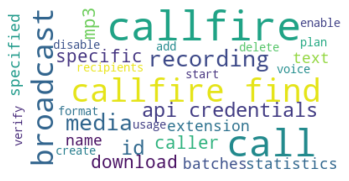

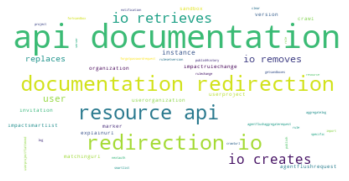

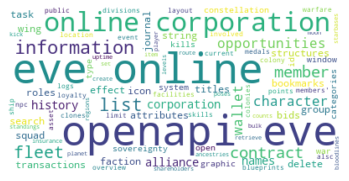

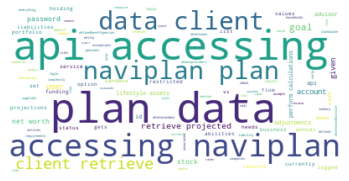

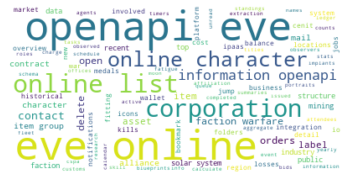

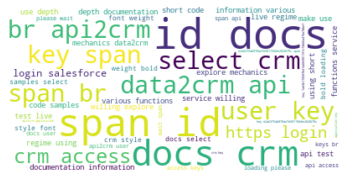

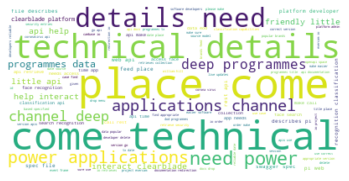

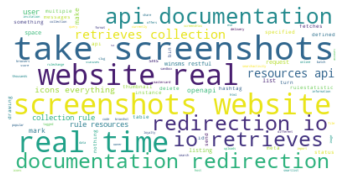

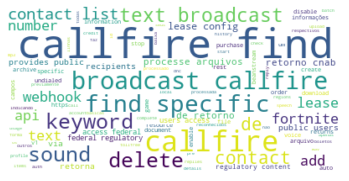

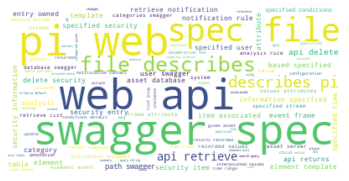

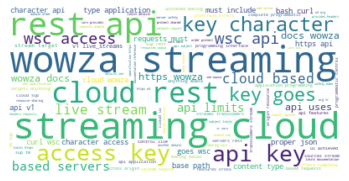

In [32]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
k_val = 15
vectorizer = TfidfVectorizer(stop_words={'english'})
apilists = apis_df["api_summary"].to_list()
X = vectorizer.fit_transform(apilists)
clusters = list(kmeans.labels_)

kmeans_result={'cluster':clusters,'apis':apilists}
kmeans_result=pd.DataFrame(kmeans_result)
for k in range(0,k_val):
    s=kmeans_result[kmeans_result.cluster==k]
    text=s['apis'].str.cat(sep=' ')
    text=text.lower()
    text=' '.join([word for word in text.split()])
    wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
    plt.figure()
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

In [35]:
kmeans_result

,cluster,apis
0,1,Stock and Forex Data and Realtime Quotes Get q...
1,3,Stock and Forex Data and Realtime Quotes Get a...
2,3,### The Internet of Things for Everyone\n\nThe...
3,3,### The Internet of Things for Everyone\n\nThe...
4,3,### The Internet of Things for Everyone\n\nThe...
...,...,...
2818,0,The world's greatest SMS API delete
2819,0,The world's greatest SMS API all
2820,0,The world's greatest SMS API single-audio
2821,0,The world's greatest SMS API single-text


In [36]:
kmeans.labels_

array([1, 3, 3, ..., 0, 0, 0], dtype=int32)

In [37]:
import collections
counter=collections.Counter(kmeans.labels_)


# APIs in Clusters

In [38]:
counter

Counter({0: 35,
         1: 359,
         2: 606,
         3: 625,
         4: 29,
         5: 51,
         6: 85,
         7: 64,
         8: 103,
         9: 186,
         10: 259,
         11: 45,
         12: 67,
         13: 202,
         14: 107})

In [40]:
from sklearn.ensemble import RandomTreesEmbedding
random_trees = RandomTreesEmbedding(n_estimators=15, random_state=0, max_depth=1).fit(X)
X_sparse_embedding = random_trees.transform(X)
X_sparse_embedding.toarray()

array([[1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 1., 0.]])

## Agglomerative Clustering

In [51]:
from sklearn.cluster import AgglomerativeClustering
import numpy as np
agglo_cluster = AgglomerativeClustering(n_clusters=17, affinity='euclidean').fit(X.toarray())

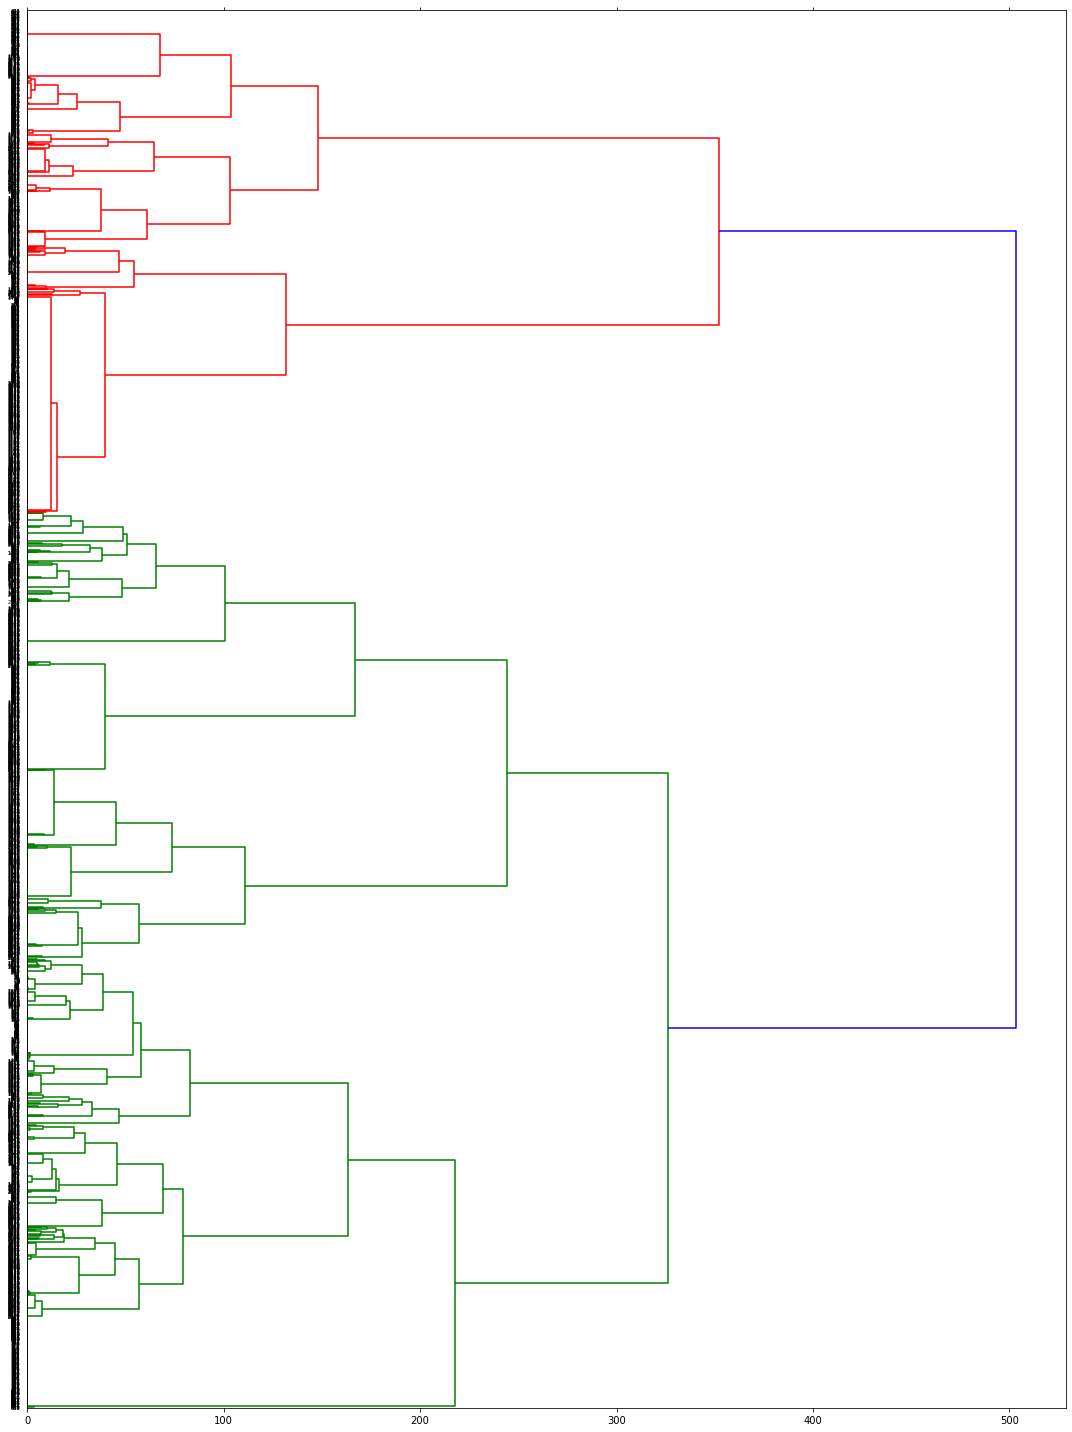

In [53]:
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, ngram_range=(1,3))
tfidf_matrix = tfidf_vectorizer.fit_transform(apis_df["processed_text"].values)
dist = 1 - cosine_similarity(tfidf_matrix)

linkage_matrix = ward(dist) #define the linkage_matrix using ward clustering pre-computed distances

fig, ax = plt.subplots(figsize=(15, 20)) # set size
ax = dendrogram(linkage_matrix, orientation="right");

plt.tick_params(\
    axis= 'x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom='off',      # ticks along the bottom edge are off
    top='off',         # ticks along the top edge are off
    labelbottom='off')

plt.tight_layout() #show plot with tight layout

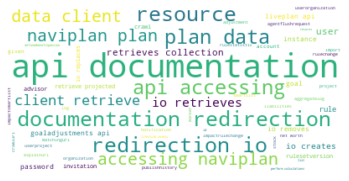

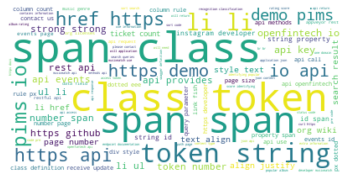

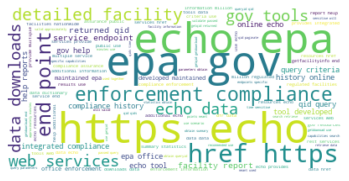

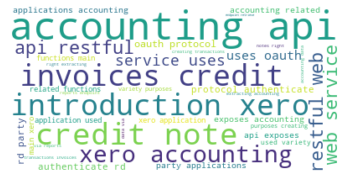

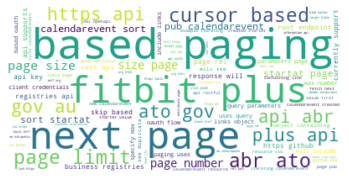

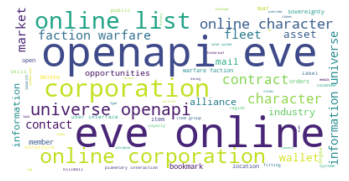

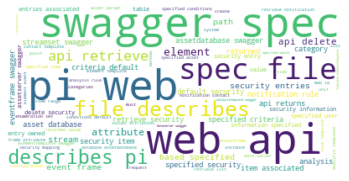

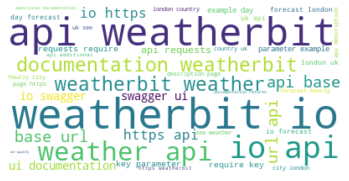

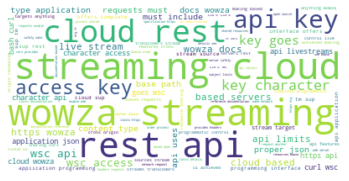

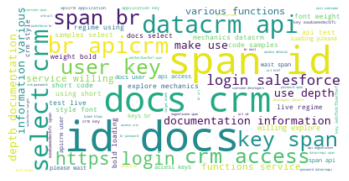

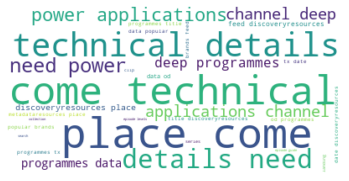

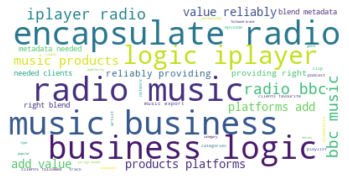

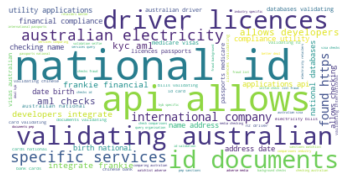

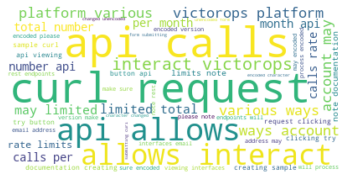

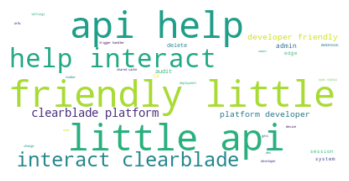

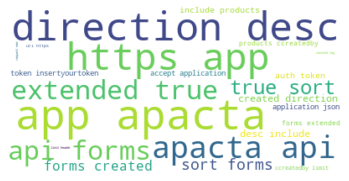

In [55]:
labels = agglo_cluster.labels_
cluster_size = 16
from wordcloud import WordCloud
result={'cluster':labels,'reviews':apis_df["processed_text"].values}
result=pd.DataFrame(result)
for k in range(0,cluster_size):
   s=result[result.cluster==k]
   text=s['reviews'].str.cat(sep=' ')
   text=text.lower()
   text=' '.join([word for word in text.split()])
   wordcloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(text)
   plt.figure()
   plt.imshow(wordcloud, interpolation="bilinear")
   plt.axis("off")
   plt.show()